# End-toEnd Sales Data Analysis

### This project showcases the use of SQL, Python to analyze Sales data for an enterprise. It also shows how to use PANEL library from Holoviz to build a data visualization app. 


<span style="font-size: 30px; color: blue; font-style: italic; font-weight: bold;">Data Collection</span>

# Import all libraries

## To connect Python/pandas to MYSQL

In [12]:
import mysql.connector

## Import Python related Libraries

In [15]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

## Import Panel related Libraries

In [18]:
from bokeh.models.formatters import NumeralTickFormatter
import panel as pn
pn.extension('tabulator')
pn.extension(sizing_mode = 'stretch_width', loading_spinner = 'petal', loading_color = '#00aa41')
pn.extension(raw_css=["""
.custom-float-input .bk-input {
    font-size: 40pt;  /* Adjust the input value font size */
}
.custom-float-input .bk-input-group > label {
    font-size: 40pt;  /* Adjust the label font size */
}
"""])
# ['petal','arc','arcs','bar','dots']
import hvplot.pandas

formatter = NumeralTickFormatter(format='0.0,a')

### The data available for this project is in the form of a SQL database. 
### There are multiple tables provided. They are customers, date, markets, products, transactions
### For the current project, Transactions table is the most important table since it helps us understand Sales information and we can then connect critical information.
#### For example: We can connect Transactions table to Customer table to get Customer name instead of customer id

## Connect to MYSQL database

In [22]:
conn = mysql.connector.connect(
host ="localhost",
user = "root",
password = "root",
database = "sales")

### Instead of pulling data by running multiple queries and then merging the data in Python, we have created a VIEW in MYSQL which joins multiple tables and get information from transactions perspective as mentioned above. 

### Few advantages: 1. Keeps the SQL query simple 2. Even if source table data changes, the query gives the latest information

#### The SQL code for VIEW is available in the project folder

In [25]:
# Pulls data to df dataframe
mycursor = conn.cursor()
mycursor.execute("SELECT * FROM finalview")
myresult = mycursor.fetchall()
df = pd.DataFrame(myresult, columns=[desc[0] for desc in mycursor.description])
mycursor.close()
conn.close()

<span style="font-size: 30px; color: blue; font-style: italic; font-weight: bold;">Data Inspection and Cleaning</span>

In [28]:
# Helps understand if there are in blanks in the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148395 entries, 0 to 148394
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   product_code              148395 non-null  object 
 1   customer_code             148395 non-null  object 
 2   market_code               148395 non-null  object 
 3   order_date                148395 non-null  object 
 4   sales_qty                 148395 non-null  int64  
 5   sales_amount              148395 non-null  float64
 6   currency                  148395 non-null  object 
 7   profit_margin_percentage  148395 non-null  float64
 8   profit_margin             148395 non-null  float64
 9   cost_price                148395 non-null  float64
 10  date                      148395 non-null  object 
 11  cy_date                   148395 non-null  object 
 12  year                      148395 non-null  int64  
 13  month_name                148395 non-null  o

In [7]:
# Helps understand if there are in blanks in the data
nan_counts = df.isna().sum()
nan_counts

product_code                    0
customer_code                   0
market_code                     0
order_date                      0
sales_qty                       0
sales_amount                    0
currency                        0
profit_margin_percentage        0
profit_margin                   0
cost_price                      0
date                            0
cy_date                         0
year                            0
month_name                      0
date_yy_mmm                     0
custmer_name                    0
customer_type                   0
markets_name                    0
zone                            0
product_type                54599
dtype: int64

In [8]:
# Helps understand all the currency is the same. If not, the price interpretation will be wrong.
#  In this case, we have few values different and it makes sense to convert all data into one of the currencies
df['currency'].unique()

array(['INR', 'USD'], dtype=object)

In [9]:
Unique_countper = df['currency'].value_counts()
Unique_countper

currency
INR    148393
USD         2
Name: count, dtype: int64

In [10]:
#  Another critical check if Sales amount has any negative values. This is the column should never be less than zero values
has_zero_or_negative_values_A = (df['sales_amount'] <= 0).any()
has_zero_or_negative_values_A
#  If it was true, we would use the code below to remove negative value rows
# df = df.loc[df.sales_amount>0]

False

In [11]:
# define a function to convert prices to INR
def convert_to_inr(row):
    if row['currency'] == 'USD':
        # assuming an exchange rate of 80 INR per USD
        return row['sales_amount'] * 80
    else:
        return row['sales_amount']

# create a new column 'Cost_Price_INR' with prices converted to INR
df['Sales_Amt_INR'] = df.apply(convert_to_inr, axis=1)

In [12]:
#  Below code is to help with visualization

df['year'] = df['year'].astype(str)
df["profit_margin_perc"] = (df["profit_margin"]/df["Sales_Amt_INR"])*100

<span style="font-size: 30px; color: blue; font-style: italic; font-weight: bold;">Data Visualization</span>

![Local Image](./Panel.jpg)

[Learn more about Panel](https://blog.holoviz.org/posts/panel_announcement/index.html)

In [13]:
#Create lists for panel widgets

Year_list = df['year'].unique().tolist()
Month_list = df['month_name'].unique().tolist()
Customer_list = df['custmer_name'].unique().tolist()
CustType_list = df['customer_type'].unique().tolist()
Market_list = df['markets_name'].unique().tolist()
Zone_list = df['zone'].unique().tolist()
ProductType_list = df['product_type'].unique().tolist()

## Design Panel Widget - You will be able to make selection from any of these filters and dashboard reflects relevant data to the selected filters

In [14]:
# Panel Widgets help to interactact with the actual visuals

SelectYear = pn.widgets.MultiSelect(name = 'Year', options = Year_list,min_width=75 ,max_width = 300, value = Year_list )
# SelectMonth = pn.widgets.MultiSelect(name = 'Month', options = Month_list, min_width=75 ,max_width = 300,  value = Month_list)
SelectCustomer = pn.widgets.MultiSelect(name = 'Customer', options = Customer_list, min_width=75 ,max_width = 300, value = Customer_list)
SelectTypeofCust = pn.widgets.MultiSelect(name = 'Customer_Type', options = CustType_list,min_width=75 ,max_width = 300, value = CustType_list)
SelectMarket = pn.widgets.MultiSelect(name = 'Market', options = Market_list, min_width=75 ,max_width = 300,  value = Market_list)
SelectZone = pn.widgets.MultiSelect(name = 'Zone', options = Zone_list, min_width=75 ,max_width = 300, value = Zone_list)
SelectProdType = pn.widgets.MultiSelect(name = 'Product Type', options = ProductType_list, min_width=75, max_width = 300, value = ProductType_list)

## Design interactive dashboard. It transforms a static pandas DataFrame into a dynamic, interactive object that can be used with Panel widgets and other interactive components.

In [15]:
idf = df.interactive()

## Below code is a key component in creating a responsive, user-driven data exploration tool or dashboard. 
## It allows for complex data filtering that updates in real-time based on user inputs, which is a powerful feature in interactive data analysis applications.

In [16]:
pipeline = (
idf[(idf.year.isin(SelectYear))&
    (idf.custmer_name.isin(SelectCustomer))&
    (idf.customer_type.isin(SelectTypeofCust))&
    (idf.markets_name.isin(SelectMarket))&
    (idf.zone.isin(SelectZone))&
    (idf.product_type.isin(SelectProdType))  
]
)

pipeline2 = (
    idf[(idf.year.isin(SelectYear)) &
        (idf.custmer_name.isin(SelectCustomer)) &
        (idf.customer_type.isin(SelectTypeofCust)) &
        (idf.markets_name.isin(SelectMarket)) &
        (idf.zone.isin(SelectZone)) &
        (idf.product_type.isin(SelectProdType))
        ].groupby(['markets_name'])[['profit_margin', 'Sales_Amt_INR']].sum()
    .reset_index()  # Reset the index to make it a DataFrame
    .assign(profit_margin_perc=lambda x: (x['profit_margin'] / x['Sales_Amt_INR']) * 100)
    .assign(profit_margin_percentage=lambda x: (x['profit_margin'] / x['profit_margin'].sum()) * 100)
    .assign(revenue_percentage=lambda x: (x['Sales_Amt_INR'] / x['Sales_Amt_INR'].sum()) * 100)
)

pipeline3 = (
    idf[(idf.year.isin(SelectYear)) &
        (idf.custmer_name.isin(SelectCustomer)) &
        (idf.customer_type.isin(SelectTypeofCust)) &
        (idf.markets_name.isin(SelectMarket)) &
        (idf.zone.isin(SelectZone)) &
        (idf.product_type.isin(SelectProdType))
        ].groupby(['custmer_name'])[['profit_margin', 'Sales_Amt_INR']].sum()
    .reset_index()  # Reset the index to make it a DataFrame
    .assign(profit_margin_perc2=lambda x: (x['profit_margin'] / x['Sales_Amt_INR']) * 100)
    .assign(profit_margin_percentage2=lambda x: (x['profit_margin'] / x['profit_margin'].sum()) * 100)
    .assign(revenue_percentage2=lambda x: (x['Sales_Amt_INR'] / x['Sales_Amt_INR'].sum()) * 100)
)

pipeline4 = (
    idf[(idf.year.isin(SelectYear)) &
        (idf.custmer_name.isin(SelectCustomer)) &
        (idf.customer_type.isin(SelectTypeofCust)) &
        (idf.markets_name.isin(SelectMarket)) &
        (idf.zone.isin(SelectZone)) &
        (idf.product_type.isin(SelectProdType))
        ].groupby(['customer_type'])[['Sales_Amt_INR']].sum()

)

pipeline5 = (
    idf[(idf.year.isin(SelectYear)) &
        (idf.custmer_name.isin(SelectCustomer)) &
        (idf.customer_type.isin(SelectTypeofCust)) &
        (idf.markets_name.isin(SelectMarket)) &
        (idf.zone.isin(SelectZone)) &
        (idf.product_type.isin(SelectProdType))
        ].groupby(['zone'])[['profit_margin', 'Sales_Amt_INR']].sum()
    .reset_index()  # Reset the index to make it a DataFrame
    .assign(profit_margin_perc3=lambda x: (x['profit_margin'] / x['Sales_Amt_INR']) * 100)
    .assign(profit_margin_percentage3=lambda x: (x['profit_margin'] / x['profit_margin'].sum()) * 100)
    .assign(revenue_percentage3=lambda x: (x['Sales_Amt_INR'] / x['Sales_Amt_INR'].sum()) * 100)
)

ProfitMarginWidget = pn.widgets.FloatInput(name='Max Profit Margin -50 to 20 range', value=5., step=0.1, start=-50, end=20, css_classes=['custom-float-input'])

## Once we have pipielines ready, we can then create Panel components to display the output. 
## Components can be indicator like Number, or a table using Tabulator widget. Sky is the limit
## Components can also be any plots. We are using hvplot here for interactivity

In [18]:
SalesQty = pipeline['sales_qty'].sum()
SalesQtyindi = pn.indicators.Number(name = "Total Sales Quantity", value = SalesQty/1e6, format = '{value:.2f}M',
                                  title_size = '15pt',
                                  font_size = '50pt',
                                   colors=[(1000, 'green'), (1000000, 'gold'), (10000000000, 'red')], align='center')

TotalProfitMargin = pipeline['profit_margin'].sum()
TotalProfitMarginindi = pn.indicators.Number(name = "Total Profit Margin ", value = TotalProfitMargin/1e6, format = '{value:.2f}M',
                                  title_size = '15pt',
                                  font_size = '50pt',
                                   colors=[(1000, 'blue'), (1000000, 'gold'), (10000000000, 'red')], align='center')

Revenue = pipeline['Sales_Amt_INR'].sum()
Revenueindi = pn.indicators.Number(name = "Total Revenue", value = Revenue/1e6, format = '{value:.2f}M',
                                  title_size = '15pt',
                                  font_size = '50pt',
                                   colors=[(1000, 'brown'), (1000000, 'gold'), (10000000000, 'red')], align='center')

In [19]:
formatter = NumeralTickFormatter(format='0.0,a')

Revbyyear = pipeline.groupby(['year'])['Sales_Amt_INR'].sum()
Revbyyearplot = Revbyyear.hvplot.line(y=['Sales_Amt_INR'], legend = "left", width=600, xlabel="Year", title="Revenue by Year", color = 'green', fontscale = 1.4, yformatter=formatter )

In [20]:
formatter = NumeralTickFormatter(format='0.0,a')
custbymarket = pipeline.pivot_table(index = "markets_name", values = "custmer_name", aggfunc = pd.Series.nunique, margins = False)
custbymarket.reset_index(inplace = True)
custbymarket = custbymarket.sort_values(by='custmer_name', ascending=True)

In [21]:
# custbymarkettable = custbymarket.pipe(pn.widgets.Tabulator, pagination='remote', header_filters = False, header_align='center', text_align='center', show_index=True, layout='fit_data' )
custbymarketplot = custbymarket.hvplot.barh('markets_name', 'custmer_name', stacked=True, rot=90, xformatter=formatter, fontscale = 1.5, color = 'green', title="Number of Customers by Market").opts(labelled=[])

In [22]:
formatter = NumeralTickFormatter(format='0.0,a')
RevbyZone = pipeline5.pivot_table(index = "zone", values = "Sales_Amt_INR", aggfunc = np.sum, margins = False)
RevbyZone.reset_index(inplace = True)
RevbyZone = RevbyZone.sort_values(by='Sales_Amt_INR', ascending=True)
RevbyZoneplot = RevbyZone.hvplot.barh('zone', 'Sales_Amt_INR',  stacked=True, rot=90, xformatter=formatter, fontscale = 1.5, color = 'orange', title="Revenue by Zone").opts(labelled=[])

In [23]:
formatter = NumeralTickFormatter(format='0.0,a')
customer = pipeline.pivot_table(index = "custmer_name", values = "Sales_Amt_INR", aggfunc = np.sum, margins = False)
customer.reset_index(inplace = True)
customer = customer.sort_values(by='Sales_Amt_INR', ascending=True)
Top5Customer = customer.tail(5)
Top5Customerplot = Top5Customer.hvplot.barh('custmer_name', 'Sales_Amt_INR',  stacked=True, rot=90, xformatter=formatter, fontscale = 1.5, color = 'violet', title="Revenue by Top 5 Customers").opts(xlabel='')

In [24]:
formatter = NumeralTickFormatter(format='0.0,a')
RevbyMarket = pipeline.pivot_table(index = ["markets_name", "customer_type"],values = "Sales_Amt_INR", aggfunc = np.sum, margins = False)
# RevbyMarket.reset_index(inplace = True)
RevbyMarket = RevbyMarket.sort_values(by='Sales_Amt_INR', ascending=True)
RevbyMarketplot = RevbyMarket.hvplot.barh(stacked=True, width = 1300, height = 1000,rot=90, xformatter=formatter, fontscale = 1.5, colormap = 'dark2', title="Revenue by Market" ).opts(xlabel='')

In [25]:
formatter = NumeralTickFormatter(format='0.0,a')
SalesQtybyMarket = pipeline.pivot_table(index = ["markets_name", "customer_type"],values = "sales_qty", aggfunc = np.sum, margins = False)
# SalesQtybyMarket.reset_index(inplace = True)
SalesQtybyMarket = SalesQtybyMarket.sort_values(by='sales_qty', ascending=True)
SalesQtybyMarketplot = SalesQtybyMarket.hvplot.barh(stacked=True, width = 1300, height = 1000,rot=90, xformatter=formatter, fontscale = 1.5, colormap = 'dark2', title="Sales Quantity by Market" ).opts(xlabel='')

In [26]:
formatter = NumeralTickFormatter(format='0.0,a')
product = pipeline.pivot_table(index = "product_code", values = "Sales_Amt_INR", aggfunc = np.sum, margins = False)
product.reset_index(inplace = True)
product = product.sort_values(by='Sales_Amt_INR', ascending=True)
Top5products = product.tail(5)
Top5productsplot = Top5products.hvplot.barh('product_code', 'Sales_Amt_INR',  stacked=True, rot=90, xformatter=formatter, fontscale = 1.5, color = 'blue', title="Revenue by Top 5 Products" ).opts(xlabel='')

In [28]:
pie = pipeline4.plot(kind='pie', y="Sales_Amt_INR", autopct='%1.0f%%', legend=False, figsize =(4,3), title="Revenue Percent by Customer Type", textprops={'fontsize': 7},ylabel="")

In [29]:
ProfMarbyMarket = pipeline2[pipeline2.profit_margin_perc < ProfitMarginWidget].sort_values(by='profit_margin_perc', ascending=True)
ProfMarbyMarketplot = ProfMarbyMarket.hvplot.barh('markets_name', 'profit_margin_perc',  stacked=True, width = 700, height = 700,rot=90, xformatter=formatter, fontscale = 1.5, color = 'purple', title="Profit Margin by Market" ).opts(xlabel='')

ProfMarbyMarket2 = pipeline2[pipeline2.profit_margin_perc < ProfitMarginWidget].sort_values(by='profit_margin_percentage', ascending=True)
ProfMarbyMarket2plot = ProfMarbyMarket2.hvplot.barh('markets_name', 'profit_margin_percentage',  stacked=True, width = 700, height = 700,rot=90, xformatter=formatter, fontscale = 1.5, color = 'green', title="Profit Margin % by Market" ).opts(xlabel='')

RevbyMar = pipeline2[pipeline2.profit_margin_perc < ProfitMarginWidget].sort_values(by='revenue_percentage', ascending=True)
RevbyMarplot = RevbyMar.hvplot.barh('markets_name', 'revenue_percentage',  stacked=True, width = 700, height = 700,rot=90, xformatter=formatter, fontscale = 1.5, color = 'orange', title="Revenue % by Market" ).opts(xlabel='')

cust_table = pipeline3[pipeline3.profit_margin_perc2 < ProfitMarginWidget].pipe(pn.widgets.Tabulator, pagination='remote', header_filters = False, header_align='center', text_align='center', show_index=False, layout='fit_data' )


## Once we have widgets and components, we can now organize them and convert into a interactive dashboard.
## We are using Golden Template here (it provides option to create tabs) but one can choose other templates or design complete new custom template
## Once design is ready, use .show() to display the dashboard
## If everything looks good, run again with .servable() to make the dashboard servable. 
## Once done, through Anaconda command prompt at .ipynb location, we can panel serve the dashboard using this Jupyter notebook. 
### panel serve SalesDashboardVersion2.ipynb --allow-websocket-origin=your_server/pc_ip_address:5006
## Once Live, you can share the link with anyone to access your dashboard. Other option is Huggingface or similar mediums where we can deploy the whole setup online

GoldenTemplate
    [js_area] HTML(None, height=0, margin=0, sizing_mode='fixed', width=0)
    [actions] TemplateActions()
    [browser_info] BrowserInfo(dark_mode=False, device_pixel_ratio=1, language='en-US', timezone='America/Los_Angeles', timezone_offset=420, webdriver=False)
    [busy_indicator] LoadingSpinner(height=20, width=20)
    [nav-2556681858864] MultiSelect(max_width=300, min_width=75, name='Year', options=['2017', '2018', ...], sizing_mode='stretch_width', value=['2017', '2018', ...])
    [nav-2556868791952] MultiSelect(max_width=300, min_width=75, name='Customer', options=['Nixon', 'Electricalsoped...], sizing_mode='stretch_width', value=['Nixon', 'Electricalsoped...])
    [nav-2556868791712] MultiSelect(max_width=300, min_width=75, name='Customer_Type', options=['E-Commerce', ...], sizing_mode='stretch_width', value=['E-Commerce', ...])
    [nav-2556868791280] MultiSelect(max_width=300, min_width=75, name='Market', options=['Nagpur', 'Delhi NCR', ...], sizing_mode='stretch_width', value=['Nagpur', 'Delhi NCR', ...])
    [nav-2556868792000] MultiSelect(max_width=300, min_width=75, name='Zone', options=['Central', 'North', ...], sizing_mode='stretch_width', value=['Central', 'North', ...])
    [nav-2556868791184] MultiSelect(max_width=300, min_width=75, name='Product Type', options=['Distribution\r', ...], sizing_mode='stretch_width', value=['Distribution\r', ...])
    [nav-2556882114352] JPG(str, sizing_mode='stretch_width')
    [main-2557386469552] Column(name='High Level Statistics', sizing_mode='stretch_width')
        [0] Row(sizing_mode='stretch_width')
            [0] Column(sizing_mode='stretch_width')
                [0] Number(align='center', colors=[(1000, 'brown'), ...], font_size='50pt', format='{value:.2f}M', name='Total Revenue', title_size='15pt', value=984.872713)
            [1] Spacer(width=300)
            [2] Column(sizing_mode='stretch_width')
                [0] Number(align='center', colors=[(1000, 'green'), ...], font_size='50pt', format='{value:.2f}M', name='Total Sales Quantity', title_size='15pt', value=2.429282)
            [3] Spacer(width=300)
            [4] Column(sizing_mode='stretch_width')
                [0] Number(align='center', colors=[(1000, 'blue'), ...], font_size='50pt', format='{value:.2f}M', name='Total Profit Margin ', title_size='15pt', value=24.65706841)
        [1] Row(sizing_mode='stretch_width')
            [0] Spacer(height=40, sizing_mode='stretch_width')
        [2] Row(sizing_mode='stretch_width')
            [0] Column(sizing_mode='stretch_width')
                [0] ParamFunction(function, _pane=HoloViews, defer_load=False, loading_indicator=True, sizing_mode='stretch_width')
            [1] Tabs(sizing_mode='stretch_width')
                [0] Column(name='Revenue By Zone', sizing_mode='stretch_width')
                    [0] ParamFunction(function, _pane=HoloViews, defer_load=False, loading_indicator=True, sizing_mode='stretch_width')
                [1] Column(name='Revenue by Top 5..., sizing_mode='stretch_width')
                    [0] ParamFunction(function, _pane=HoloViews, defer_load=False, loading_indicator=True, sizing_mode='stretch_width')
                [2] Column(name='Revenue by Top 5..., sizing_mode='stretch_width')
                    [0] ParamFunction(function, _pane=HoloViews, defer_load=False, loading_indicator=True, sizing_mode='stretch_width')
        [3] Row(sizing_mode='stretch_width')
            [0] Spacer(height=40, sizing_mode='stretch_width')
        [4] Row(sizing_mode='stretch_width')
            [0] ParamFunction(function, _pane=Matplotlib, defer_load=False, loading_indicator=True, sizing_mode='stretch_width')
            [1] Spacer(width=100)
            [2] ParamFunction(function, _pane=HoloViews, defer_load=False, loading_indicator=True, sizing_mode='stretch_width')
    [main-2557386654064] Column(name='Level 1 Statistics', sizing_mode='stretch_width')
        [0] Row(sizing_mode='stretch_width')
            [0] Spacer(w
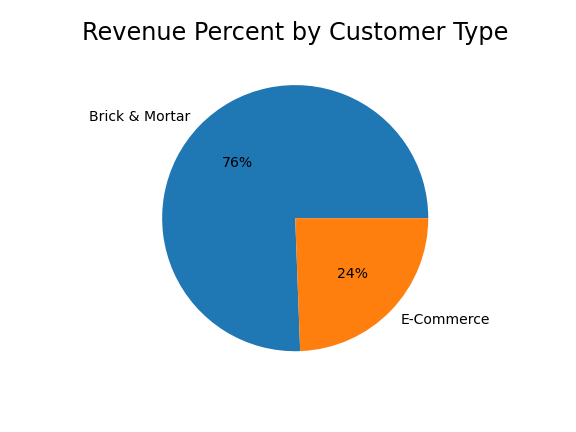
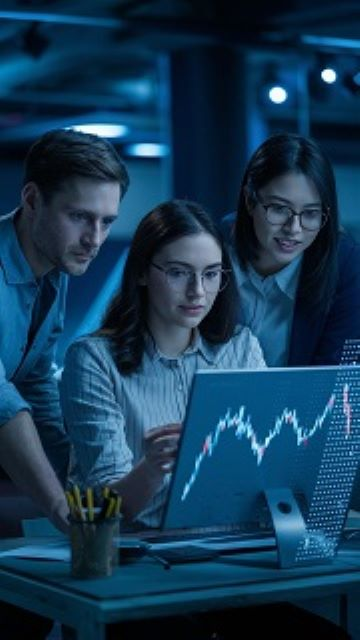

In [31]:
pn.param.ParamMethod.loading_indicator = True

GoldenTemplate = pn.template.GoldenTemplate(title = "Sales Insights Dashboard", sidebar_width = 25, main_max_width = "2500px",
                                           header_background = '#DAA520')

GoldenTemplate.sidebar.append(SelectYear)
GoldenTemplate.sidebar.append(SelectCustomer)
GoldenTemplate.sidebar.append(SelectTypeofCust)
GoldenTemplate.sidebar.append(SelectMarket)
GoldenTemplate.sidebar.append(SelectZone)
GoldenTemplate.sidebar.append(SelectProdType)
GoldenTemplate.sidebar.append(pn.pane.JPG(r'C:\Users\Maddy\Documents\Python\Data Science\SQL\Sales_Codebasics_project\image.jpg'))
# GoldenTemplate.sidebar.append(ProfitMarginWidget)

component1 = pn.Column(pn.Row(pn.Column(Revenueindi),pn.Spacer(width=300),pn.Column(SalesQtyindi),pn.Spacer(width=300),pn.Column(TotalProfitMarginindi)),
                       pn.Row(pn.Spacer(height=40)),
                       pn.Row(pn.Column(Revbyyearplot.panel()),
                              pn.Tabs(pn.Column(RevbyZoneplot.panel(), name = "Revenue By Zone"),
                                     pn.Column(Top5Customerplot.panel(), name = "Revenue by Top 5 Customers"),
                                     pn.Column(Top5productsplot.panel(), name = "Revenue by Top 5 Products"))),
                       pn.Row(pn.Spacer(height=40)),
                       pn.Row(pie.panel(), pn.Spacer(width=100), custbymarketplot.panel() ),
                       name = "High Level Statistics")


component2 = pn.Column(pn.Row(pn.Spacer(width=100), pn.Tabs(pn.Column(RevbyMarketplot.panel(), name = "Revenue by Market"),
                                     pn.Column(SalesQtybyMarketplot.panel(), name = "Sales Quantity by Market"))),
                       pn.Row(pn.Spacer(height=20)),
                       name = "Level 1 Statistics")

component3 = pn.Column(pn.Row(pn.Column(ProfitMarginWidget)),
                       pn.Row(pn.Spacer(height=10)),
                       pn.Row(pn.Column(cust_table.panel()), pn.Spacer(width=20), pn.Tabs(pn.Column(ProfMarbyMarketplot.panel(), name = "Profit Margin by Market"),
                                     pn.Column(ProfMarbyMarket2plot.panel(), name = "Profit Margin Percentage by Market"),
                                     pn.Column(RevbyMarplot.panel(), name = "Revenue Percentage by Market"))),
                       pn.Row(),
                       name = "Level 2 Statistics")

GoldenTemplate.main.append(component1)
GoldenTemplate.main.append(component2)
GoldenTemplate.main.append(component3)



GoldenTemplate.servable()